In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pysam
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import pandas as pd
import pyranges as pr
from itertools import repeat
import pyBigWig
from collections import Counter

In [3]:
# get last pa sites
# get single polya site gene

last_pa_bed = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.last_polya_cluster_summit.bed'
last_pa = pr.read_bed(last_pa_bed, as_df=True)
last_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
last_pa.loc[:, 'Chromosome'] = last_pa.loc[:, 'Chromosome'].astype('str')

mask = last_pa.loc[:, 'Name'].str.contains('_1')
single_pa_site_gene = last_pa[mask].loc[:, 'Name'].map(lambda x: x.split('_')[0])

last_pa['Name'] = last_pa['Name'].map(lambda x: x.split('_')[0])
last_pa = last_pa.set_index(['Name'])


# get gene model

gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])

In [4]:
# get protein-coding gene

protein_coding_bed = '/public/home/mowp/db/Arabidopsis_thaliana/bed/Araport11_protein_coding.201606.bed'
protein_coding = pr.read_bed(protein_coding_bed, as_df=True)

protein_coding_gene = set(protein_coding['Name'].map(lambda x: x.split('.')[0]))

In [6]:
%store -r output_res
all_gene = set(output_res['gene_id'])

# three prime end distribution

## for nanopore 

In [ ]:
infile = '/public/home/mowp/db/Arabidopsis_thaliana/intergenic_region/araport11.distance_to_downstream_gene.bed'
distance_to_downstream = pr.read_bed(infile, as_df=True)

distance_to_downstream['upstream'] = distance_to_downstream['Name'].map(lambda x: x.split('_')[0])
distance_to_downstream['downstream'] = distance_to_downstream['Name'].map(lambda x: x.split('_')[1])

same_strand_gene = set(distance_to_downstream.query('Score == 1')['upstream'])
different_strand_gene = set(distance_to_downstream.query('Score == 0')['upstream'])

In [158]:
def get_target_site(site_type, gene_id):
    if site_type == 'PAS':
        return last_pa.at[gene_id, 'End']
    elif site_type == 'TSS':
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        try:
            values = tss_bed.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
        except KeyError:
            values = gene_model.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
            
    elif site_type == 'TES':
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        values = gene_model.loc[gene_id, :].values
        if values[4] == '+':
            return values[2]
        else:
            return values[1]
        
    elif site_type == 'downstream':
        try:
            downstream_gene = distance_to_downstream.query('upstream == @gene_id')['downstream'].values[0]
            v = distance_to_downstream.query('upstream == @gene_id').values[0]
            start = (v[1]+v[2])//2
            # start = gene_model.loc[downstream_gene, :].values[1]
            values = gene_model.loc[downstream_gene, :].values
            if abs(values[1]-start) < abs(values[2]-start):
                return values[1]
            else:
                return values[2]
        except:
            return None
                                      
    else:
        raise KeyError

In [ ]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_three_end_pos(infile, gene_id, before, after):
    chrom, *_, strand = gene_model.loc[gene_id]
    strand_boo = STRAND_TO_BOOL[strand]
    if chrom in {'Pt', 'Mt'}:
        return None
    
    n = 0
    cov_list = []
    read_set = set()

    target_site = get_target_site('PAS', gene_id)
    downstream = get_target_site('downstream', gene_id)
    if downstream is None:
        return
    
    three_end_pos = np.zeros(before+after)

    if strand == '+':
        start = target_site-before
        end = target_site+after
    else:
        start = target_site-after
        end = target_site+before
    if start <= 0:
        return

    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            read_strand = read.is_reverse
            if strand_boo is not read_strand:
                continue

            if strand == '+':
                read_three_end = read.reference_end-target_site
                read_five_end = read.reference_start
                if read_five_end > downstream - 100:
                    continue
            else:
                read_three_end = target_site-read.reference_start
                read_five_end = read.reference_end
                if read_five_end < downstream + 100:
                    continue

            if -before <= read_three_end < after:
                three_end_pos[read_three_end+before] += 1

    if sum(three_end_pos) >= 15:
        return three_end_pos


def get_three_end_pos_turbo(infile, gene_list, before=1000, after=1000, threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list)/threads)
        results = e.map(get_three_end_pos, repeat(infile), gene_list, repeat(before), repeat(after), chunksize=chunksize)
    
    n = 0
    three_end_pos = np.zeros(before+after)
    for res in results:
        if res is not None and sum(res) > 0:
            three_end_pos += res/sum(res)
            n += 1
    return three_end_pos, n


## for illumina 

In [137]:
def get_target_site(site_type, gene_id):
    if site_type == 'PAS':
        return last_pa.at[gene_id, 'End']
    elif site_type == 'TSS':
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        try:
            values = tss_bed.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
        except KeyError:
            values = gene_model.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
            
    elif site_type == 'TES':
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        values = gene_model.loc[gene_id, :].values
        if values[4] == '+':
            return values[2]
        else:
            return values[1]
    else:
        raise KeyError


STRAND_TO_BOOL = {'-': True, '+': False}
def get_ngs_three_end_pos(infile, gene_id, before=1000, after=1000):
    chrom, *_, strand = gene_model.loc[gene_id]
    strand_boo = STRAND_TO_BOOL[strand]
    if chrom in {'Pt', 'Mt'}:
        return None
    
    n = 0
    cov_list = []
    read_set = set()

    target_site = get_target_site('PAS', gene_id)
    three_end_pos = np.zeros(before+after)

    if strand == '+':
        start = target_site-before
        end = target_site+after
    else:
        start = target_site-after
        end = target_site+before

    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            read_strand = read.is_reverse
            if strand_boo is not read_strand:
                continue

            if strand == '+':
                read_three_end = read.reference_end-target_site
            else:
                read_three_end = target_site-read.reference_start

            if -before <= read_three_end < after:
                three_end_pos[read_three_end+before] += 1

    if sum(three_end_pos) >= 20:
        return three_end_pos


def get_ngs_three_end_pos_turbo(infile, gene_list, threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list)/threads)
        results = e.map(get_ngs_three_end_pos, repeat(infile), gene_list, chunksize=chunksize)
    
    n = 0
    three_end_pos = np.zeros(2000)
    for res in results:
        if res is not None and sum(res[800:]) > 0:
            three_end_pos += res/sum(res[800:])
            n += 1
    return three_end_pos, n


## FLEP-seq

### cbRNA

In [72]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'

cb_three_end_pos, cb_n = get_three_end_pos_turbo(infile, all_gene)

In [75]:
pal = sns.color_palette("tab10")
sns.set_palette(pal)

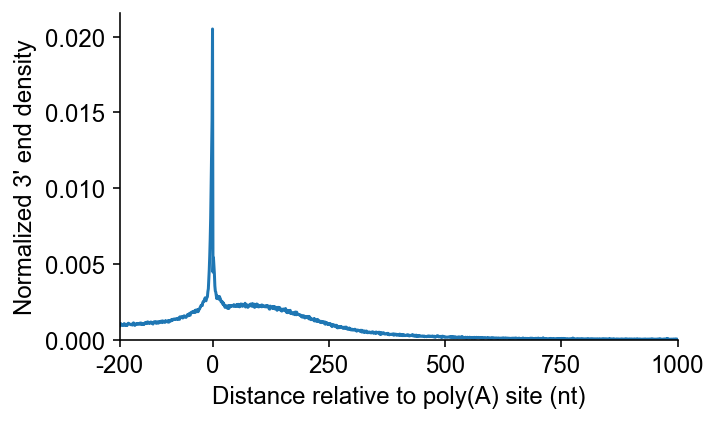

In [76]:
plt.figure(figsize=(5, 3))
# plt.axvline(1000, ls='--', color='#555555')
plt.plot(cb_three_end_pos/cb_n)
#plt.plot(polya_three_end_pos/polya_n)

plt.xlabel('Distance relative to poly(A) site (nt)')
plt.ylabel('Normalized 3\' end density')
xticks = np.array([800, 1000, 1250, 1500, 1750, 2000])
plt.xticks(xticks, xticks-1000)
plt.ylim(0)
plt.xlim(800, 2000)
sns.despine(top=True, right=True)

### nuclear RNA

In [146]:
infile = '/public/home/mowp/test/nanopore_test/20210324_col_nuclear/elongating_data/20210324_col_nuclear.elongating.bam'
nuclear_three_end_pos, nuclear_n = get_three_end_pos_turbo(infile, all_gene)

# infile = '/public/home/mowp/workspace/termination/cbRNA_pool/polyadenylated_data/polyadenylated_data.bam'
# polya_three_end_pos, polya_n = get_three_end_pos_turbo(infile, all_gene)

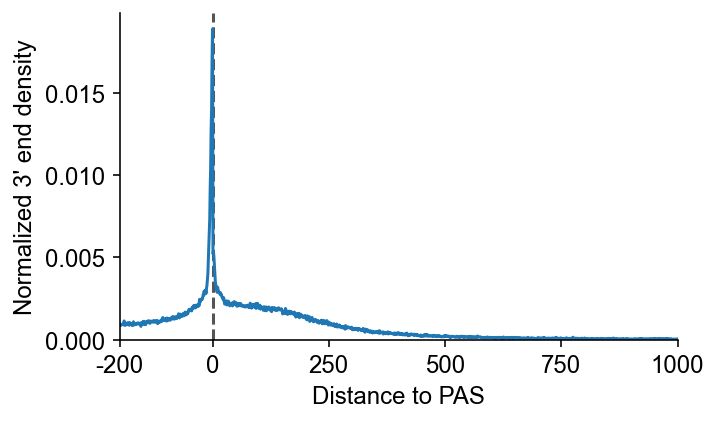

In [23]:
plt.figure(figsize=(5, 3))
plt.axvline(1000, ls='--', color='#555555')
plt.plot(nuclear_three_end_pos/nuclear_n)
#plt.plot(polya_three_end_pos/polya_n)

plt.xlabel('Distance to PAS')
plt.ylabel('Normalized 3\' end density')
xticks = np.array([800, 1000, 1250, 1500, 1750, 2000])
plt.xticks(xticks, xticks-1000)
plt.ylim(0)
plt.xlim(800, 2000)
sns.despine(top=True, right=True)

### xrn3 nuclear RNA

In [154]:
infile = '/public/home/mowp/test/nanopore_test/20210301_xrn3/elongating_data/20210301_xrn3.elongating.bam'
xrn3_three_end_pos, xrn3_n = get_three_end_pos_turbo(infile, all_gene)

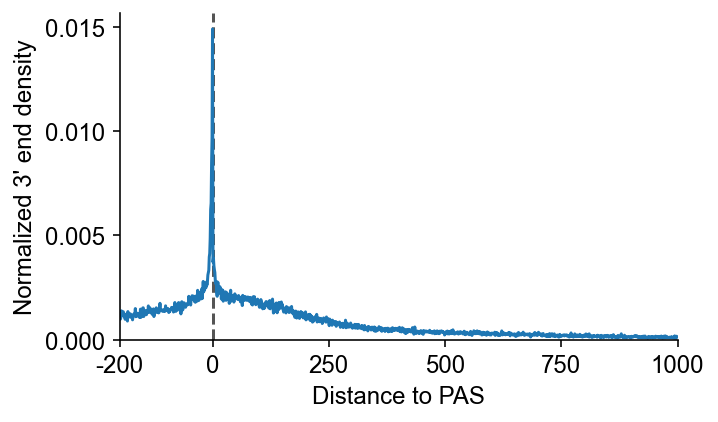

In [155]:
plt.figure(figsize=(5, 3))
plt.axvline(1000, ls='--', color='#555555')
plt.plot(xrn3_three_end_pos/xrn3_n)
#plt.plot(polya_three_end_pos/polya_n)

plt.xlabel('Distance to PAS')
plt.ylabel('Normalized 3\' end density')
xticks = np.array([800, 1000, 1250, 1500, 1750, 2000])
plt.xticks(xticks, xticks-1000)
plt.ylim(0)
plt.xlim(800, 2000)
sns.despine(top=True, right=True)

### xrn3 vs WT

In [209]:
infile = '/public/home/mowp/test/nanopore_test/20210324_col_nuclear/elongating_data/20210324_col_nuclear.elongating.bam'
nuclear_three_end_pos, nuclear_n = get_three_end_pos_turbo(infile, all_gene, before=200, after=1500)

In [210]:
infile = '/public/home/mowp/test/nanopore_test/20210301_xrn3/elongating_data/20210301_xrn3.elongating.bam'
xrn3_three_end_pos, xrn3_n = get_three_end_pos_turbo(infile, all_gene, before=200, after=1500)

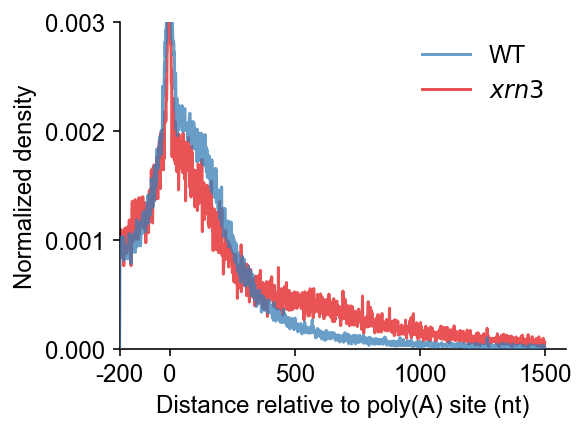

In [233]:
plt.figure(figsize=(4, 3))
plt.plot(nuclear_three_end_pos/nuclear_n, alpha=.75, label='WT', color='#377EB8', zorder=10)
plt.plot(xrn3_three_end_pos/xrn3_n, alpha=.75, label='$\mathit{xrn3}$', color='#E41A1C')
plt.ylim(0, 0.003)
plt.xlim(0)
# ax[1].axvline(200, ls='--', color='#555555')
plt.ylabel('Normalized density')
plt.yticks([0, .001, .002, .003])
xticks = np.array([0, 200, 700, 1200, 1700])
plt.xticks(xticks, xticks-200)
plt.xlabel('Distance relative to poly(A) site (nt)')

plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.savefig('a.svg')

## plaNET-seq

In [86]:
infile = '/public/home/lab-zhai/edit_share/jbrowse/tair10/Kindgren_2019_GSE131733/s01_WT_RT_rep1/aligned_data/s01_WT_RT_rep1.bam'

pnet_three_end_pos, pnet_n = get_ngs_three_end_pos_turbo(infile, all_gene)

## GRO-seq

In [138]:
infile = '/public/home/mowp/test/GRO_seq/GRO_seq_GSE100010_NatPlant_2018/GROseq_col_rep1_GSM2667813/aligned_data/GROseq_col_rep1_GSM2667813.sorted.rmdup.bam'

gro_three_end_pos, gro_n = get_ngs_three_end_pos_turbo(infile, all_gene)

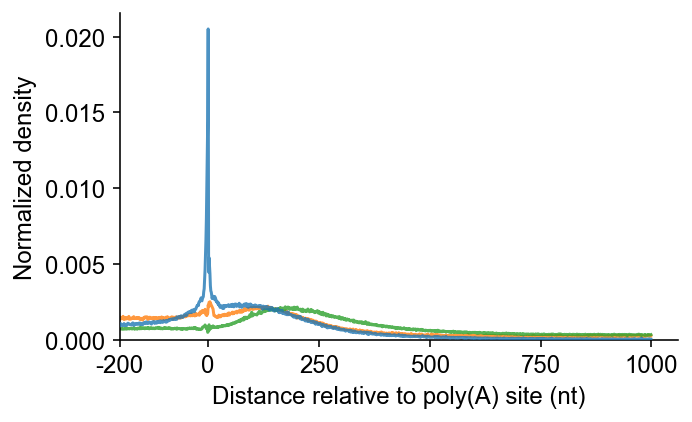

In [145]:
plt.figure(figsize=(5, 3))
plt.plot(cb_three_end_pos[800:]/cb_n, label='FLEP-seq', zorder=10, alpha=.8)
plt.plot(pnet_three_end_pos[800:]/pnet_n, label='plaNET-seq', alpha=.8)
plt.plot(gro_three_end_pos[800:]/gro_n, label='GRO-seq', alpha=.8)

plt.xlabel('Distance relative to poly(A) site (nt)')
plt.ylabel('Normalized density')
xticks = np.array([0, 200, 450, 700, 950, 1200])
plt.xticks(xticks, xticks-200)
plt.ylim(0)
plt.xlim(0)
# plt.legend(frameon=False)
sns.despine(top=True, right=True)

# five prime end distribution

In [11]:
def get_target_site(site_type, gene_id):
    if site_type == 'PAS':
        # 获取基因PAS
        return last_pa.at[gene_id, 'End']
    elif site_type == 'TSS':
        # 获取基因TSS
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        try:
            values = tss_bed.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]
        except KeyError:
            values = gene_model.loc[gene_id, :].values
            if values[4] == '+':
                return values[1]
            else:
                return values[2]

    elif site_type == 'TES':
        # 获取基因TES
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        values = gene_model.loc[gene_id, :].values
        if values[4] == '+':
            return values[2]
        else:
            return values[1]
    else:
        raise KeyError


STRAND_TO_BOOL = {'-': True, '+': False}


def get_five_end_pos(infile, gene_id, before, after):
    chrom, *_, strand = gene_model.loc[gene_id]
    strand_boo = STRAND_TO_BOOL[strand]
    if chrom in {'Pt', 'Mt'}:
        return None

    n = 0
    cov_list = []
    read_set = set()

    target_site = get_target_site('PAS', gene_id)
    five_end_pos = np.zeros(before + after)

    if strand == '+':
        start = target_site - before
        end = target_site + after
    else:
        start = target_site - after
        end = target_site + before
    
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            read_strand = read.is_reverse
            if strand_boo is not read_strand:
                continue

            read_gene_id = read.get_tag('gi')
            if read_gene_id not in {gene_id, 'None'} and strand == gene_model.at[read_gene_id, 'Strand']:
                try:
                    if strand == '+' and gene_model.at[read_gene_id, 'Start']-150 < read.reference_start:
                        continue
                    elif strand == '-' and gene_model.at[read_gene_id, 'End']+150 > read.reference_end:
                        continue
                except KeyError:
                    continue
                
            if strand == '+':
                read_five_end = read.reference_start - target_site
            else:
                read_five_end = target_site - read.reference_end
            
            if -before <= read_five_end < after:
                five_end_pos[read_five_end + before] += 1
            
            if read_five_end >= 0:
                n += 1
    if sum(five_end_pos) >= 15 and n >= 10:
        return five_end_pos


def get_five_end_pos_turbo(infile,
                           gene_list,
                           before=200,
                           after=1000,
                           threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list) / threads)
        results = e.map(get_five_end_pos,
                        repeat(infile),
                        gene_list,
                        repeat(before),
                        repeat(after),
                        chunksize=chunksize)

    n = 0
    five_end_pos = np.zeros(before + after)
    for res in results:
        if res is not None:
            five_end_pos += res / sum(res)
            n += 1
    return five_end_pos, n

## FLEP-seq nuclear RNA

In [235]:
infile = '/public/home/mowp/test/nanopore_test/20210324_col_nuclear/elongating_data/20210324_col_nuclear.elongating.bam'
nuclear_five_end_pos, nuclear_n = get_five_end_pos_turbo(infile, all_gene)

In [236]:
infile = '/public/home/mowp/test/nanopore_test/20210301_xrn3/elongating_data/20210301_xrn3.elongating.bam'
xrn3_five_end_pos, xrn3_n = get_five_end_pos_turbo(infile, all_gene)

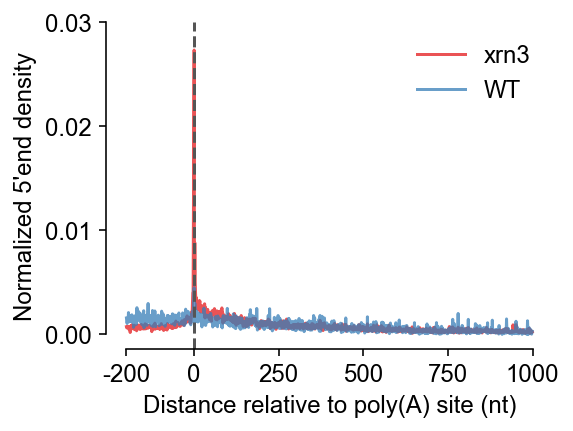

In [19]:
pal = sns.color_palette("Set1")
sns.set_palette(pal)
plt.figure(figsize=(4, 3))
plt.plot(xrn3_five_end_pos/xrn3_n, alpha=.75, label='xrn3')
plt.plot(nuclear_five_end_pos/nuclear_n, alpha=.75, label='WT')
# plt.plot(xrn2_five_end_pos/xrn2_n, alpha=.75, label='xrn2')

plt.legend(frameon=False)
# plt.ylim(0)
# plt.xlim(0)
xticks = np.array([0, 200, 450, 700, 950, 1200])
plt.xticks(xticks, xticks-200)
plt.yticks([0, .01, .02, .03])
plt.axvline(200, ls='--', color='#555555')
plt.xlabel('Distance relative to poly(A) site (nt)')
plt.ylabel('Normalized 5\'end density')
sns.despine(top=True, right=True, trim=True)

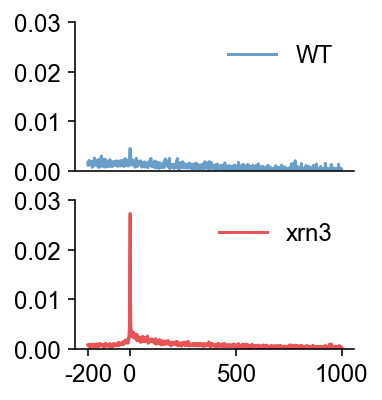

In [83]:
fig, ax = plt.subplots(2, figsize=(2.5, 3))
ax[0].plot(nuclear_five_end_pos/nuclear_n, alpha=.75, label='WT', color='#377EB8')
ax[0].set_ylim(0, .03)
ax[0].xaxis.set_major_locator(ticker.NullLocator())
ax[0].legend(frameon=False)
# ax[0].axvline(200, ls='--', color='#555555')

ax[1].plot(xrn3_five_end_pos/xrn3_n, alpha=.75, label='xrn3', color='#E41A1C')
ax[1].set_ylim(0, .03)
# ax[1].axvline(200, ls='--', color='#555555')

xticks = np.array([0, 200, 700, 1200])
plt.xticks(xticks, xticks-200)
sns.despine(top=True, right=True)
# plt.xlabel('Distance relative to poly(A) site (nt)')
plt.legend(frameon=False)

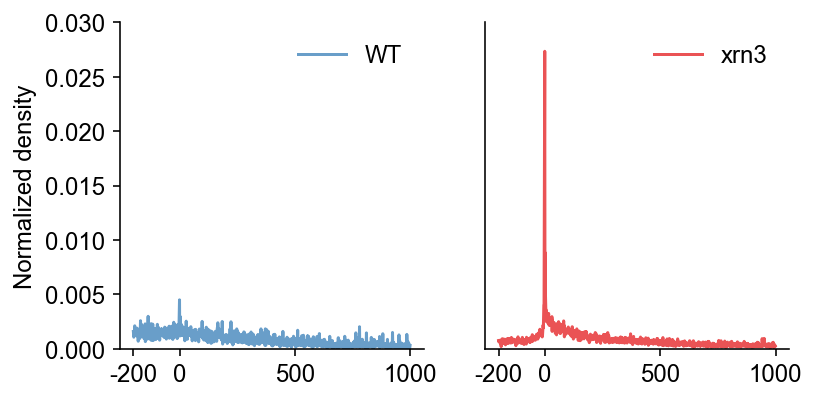

In [247]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(nuclear_five_end_pos/nuclear_n, alpha=.75, label='WT', color='#377EB8')
ax[0].set_ylim(0, .03)
ax[0].legend(frameon=False)
xticks = np.array([0, 200, 700, 1200])
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks-200)
ax[0].set_ylabel('Normalized density')

ax[1].plot(xrn3_five_end_pos/xrn3_n, alpha=.75, label='xrn3', color='#E41A1C')
ax[1].set_ylim(0, .03)
ax[1].yaxis.set_major_locator(ticker.NullLocator())
# ax[1].axvline(200, ls='--', color='#555555')


plt.xticks(xticks, xticks-200)
sns.despine(top=True, right=True)
# plt.xlabel('Distance relative to poly(A) site (nt)')
plt.legend(frameon=False)